**Analyst**: Marco Cruz

**Date**: 11-07-2023

**Cleaning and EDA Notebook**: 

**Dataset**: [FitBit Fitness Tracker - Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit)



# Bellabeat Trend Analysis

## Business Task:
    Based on the analysis of a public dataset hosted on the Kaggle platform (link above), our goal is to identify possible trends that can help Bellabeat position itself in the market for smart accessories that help users on their way to a healthier lifestyle, or for athletes who want to track their performance in a simple and digital way.

## The Analysis:
    The analysis was developed using Jupyter Notebook and Python (Pandas, Matplotlib, and Seaborn libraries). The data didn't have many discrepant or null values, which made the job of cleaning it up much easier. There are several files with tons of data that could be used to generate insights, but some were already merged and semi-summarized, which gave us the advantage of having a micro and macro view of the context captured in this data quite easily.
### About the data:
    The data delivers 33 anonymized individuals who surrendered their data registered in FitBit for one month (April to May, 2016). This data includes:
    1. Training time data; (date and time it took place)
    2. Workout intensity data;
    3. Data on the user's sleeping time;
    4. Data on the user's weight monitoring.
    


## Beginning the analysis:

#### Importing libraries:

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
pd.options.display.float_format = "{:.2f}".format

# Creating a useful function for showing pecentage an absolute numbers on pieplots
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#### Loading data:

In [47]:
#The daily activity dataset
dailyActivity = pd.read_csv("./dailyActivity_merged.csv") 

#The daily sleep dataset
dailySleep = pd.read_csv("./sleepDay_merged.csv")

#The weight info dataset
weightInfo = pd.read_csv("./weightLogInfo_merged.csv")

#The workout intensity dataset
mets = pd.read_csv("./minuteMETsNarrow_merged.csv")

### 1.0 - Daily Activities

    We need to understand which days were the most active. So, we grouped the data by day of the week to get a broader view of when people were working out the most.

In [48]:
#Converting ActivityDate from string to datetime.
dailyActivity["ActivityDate"] = pd.to_datetime(dailyActivity["ActivityDate"], format="%m/%d/%Y")

#Creating a new feature with the names of the week days.
dailyActivity["Weekday"] = dailyActivity["ActivityDate"].apply(lambda x: x.weekday())\
.replace({
    0 : "Monday",
    1 : "Tuesday",
    2 : "Wednesday",
    3 : "Thursday",
    4 : "Friday",
    5 : "Saturday",
    6 : "Sunday"
})
"""
    We can think of physical activity as taking place when we are not in a sedentary mode.
    So we created a new feature that sums up the times in minutes of low, moderate and high 
    activity and converts them to hours for easier visualization.
"""
dailyActivity["TotalActivity"] = (dailyActivity["VeryActiveMinutes"] + dailyActivity["FairlyActiveMinutes"] + dailyActivity["LightlyActiveMinutes"]) / 60

#We grouped this data into days of the week.
grpWkday = dailyActivity.groupby(["Weekday"])\
    .agg({
        "Id" : "count",
        "TotalDistance" : ["sum", "mean"],
        "Calories" : ["sum", "mean"],
        "TotalActivity" : ["sum", "mean"]
    })\
    .sort_values(("TotalActivity", "sum"), ascending=False)\
    .reset_index()

#### 1.1 Total workout hours performed by Weekday.

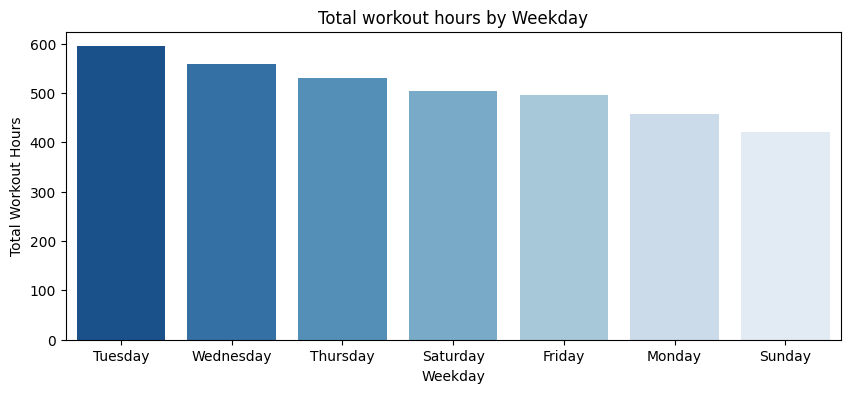

In [49]:
plt.subplots(figsize=(10, 4))
sns.barplot(data=grpWkday, x="Weekday", y=("TotalActivity", "sum"), palette="Blues_r")\
.set(xlabel="Weekday", 
     ylabel="Total Workout Hours", 
     title="Total workout hours by Weekday")
plt.show()

#### 1.2 Average workout hours by Weekday

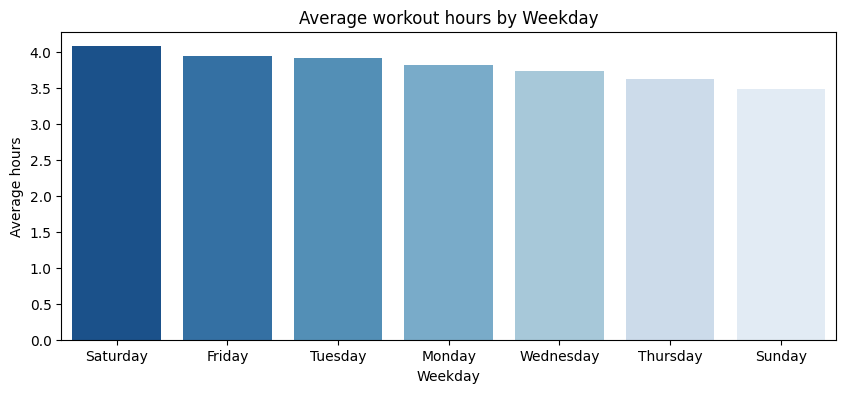

In [50]:
plt.subplots(figsize=(10, 4))
sns.barplot(data=grpWkday.sort_values(("TotalActivity", "mean"), ascending=False),
            x="Weekday", y=("TotalActivity", "mean"), palette="Blues_r")\
            .set(xlabel="Weekday",
                 ylabel="Average hours",
                 title="Average workout hours by Weekday")
plt.show()

#### 1.3 Conclusion 1:
    Most workout sessions take place from Tuesday to Thursday. However, the longest training sessions take place on Saturdays and Fridays.
    We can surely explore more data to understand these insights deeply.

### 2.0 Workout Intensity

#### What are METs?
    METs are a measure of an individual's physical effort relative to their mass. For the purposes of this analysis, the higher the number of METs, the greater the effort and energy expenditure on this activity. Most METs recorded are above 11 units, which is already a high-intensity physical activity.

#### 2.1 Grouping METs by Weekday
    We grouped METs by weekday. We did this to see which days people put more effort into their physical activity.

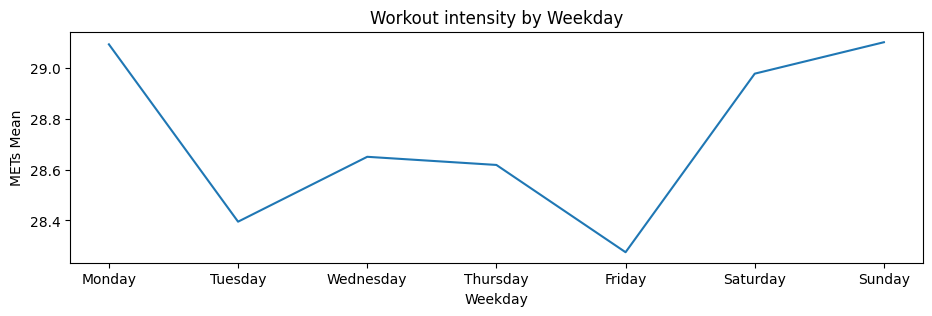

In [51]:
#Creating a new feature as Weekday
mets["Weekday"] = pd.to_datetime(mets["ActivityMinute"], format="%m/%d/%Y %I:%M:%S %p").apply(lambda x: x.weekday())\
.replace({
    0 : "Monday",
    1 : "Tuesday",
    2 : "Wednesday",
    3 : "Thursday",
    4 : "Friday",
    5 : "Saturday",
    6 : "Sunday"
})

#Making another feature to make easier to sort the weekdays in a logical way.
mets["WeekdayNum"] = pd.to_datetime(mets["ActivityMinute"], format="%m/%d/%Y %I:%M:%S %p").apply(lambda x: x.weekday())

#Grouping the data.
grpWdayMets = mets[mets["METs"] >= 12].groupby(["WeekdayNum", "Weekday"])\
.agg({
    "METs" : ["count", "mean", "max", "sum"]
}).reset_index()
"""
Since we wanted to understand the days when the most intense workouts were performed,
we filtered the dataset for METs starting at 12 units. This action reduced the noise and gave 
us a clearer picture of what was actually happening on these weekdays.
"""

plt.subplots(figsize=(11, 3))
wkdLplot = sns.lineplot(data=grpWdayMets, x="Weekday", y=("METs", "mean"))
wkdLplot.set(xlabel="Weekday",
          ylabel="METs Mean",
          title="Workout intensity by Weekday")

plt.show(wkdLplot)

    Although most of the training takes place from Tuesday to Thursday, from Saturday to Monday we have more intense training sessions than those that take place on the other weekdays.

#### 2.2 What are the most active times?
    We have already understood the training patterns during the days of the week in terms of intensity and volume. To dig even deeper, we need to understand what are the times when most of the workouts occur on those days.

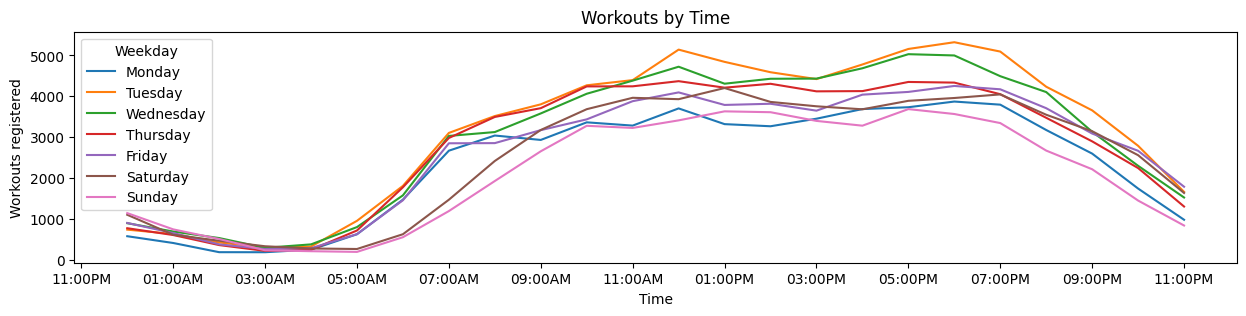

In [52]:
#Isolating Time from Date
mets["Time"] = mets["ActivityMinute"].apply(lambda x: x.split(sep=" ")[1] + " " + x.split(sep=" ")[2])
mets["Time"] = pd.to_datetime(mets["Time"], format="%I:%M:%S %p")

#Grouping By Weekday and Time
grpTimeWkday = mets[mets["METs"] >= 11].groupby(["WeekdayNum", "Weekday", pd.Grouper(key='Time', freq='60min')])\
    .agg({
        "METs" : "count"
    })

#Plotting a lineplot
plt.subplots(figsize=(15, 3))
tPolotHue = sns.lineplot(data=grpTimeWkday, x="Time", y="METs",
                         hue="Weekday")
tPolotHue.xaxis.set_major_locator(mdates.HourLocator(interval=2))
tPolotHue.xaxis.set_major_formatter(mdates.DateFormatter('%I:%M%p'))
tPolotHue.set(xlabel="Time",
          ylabel="Workouts registered",
          title="Workouts by Time")

plt.show(tPolotHue)

    As expected, training starts later on the weekends; however, we have a homogeneous time curve that runs from 9:00AM to 9:00PM, peaking between 1:00PM and 6:00PM. 

#### 2.3 Conclusion 2:
    The most intense training takes place from Saturday to Monday, with peaks on the weekends.

    There is a homogeneous curve describing the training schedule that gives us a range from 9:00AM to 9:00PM, with its peak at the afternoon. This pattern basically repeats itself for every day of the week.

### 3.0 Feature Usability
      Although there are plenty of physical activity records, not every user takes full advantage of the available features, as we can see below:

In [53]:
#Creating a comparison dataframe
IdAnalysis = pd.DataFrame()

IdAnalysis["Users"] = dailyActivity["Id"].unique()

IdAnalysis["MonitoredSleep"] = IdAnalysis["Users"].apply(lambda x: True if x in dailySleep["Id"].unique() else False)
IdAnalysis["MonitoredWeight"] = IdAnalysis["Users"].apply(lambda x: True if x in weightInfo["Id"].unique() else False)

#Show how many people monitored their sleep.
monitSleep = {
    "values": [IdAnalysis["MonitoredSleep"].sum(), IdAnalysis.shape[0] - IdAnalysis["MonitoredSleep"].sum()],
    "labels": ["Monitored", "Unmonitored"]
}

#Show how many people monitored their weight
monitWeight = {
    "values": [IdAnalysis["MonitoredWeight"].sum(), IdAnalysis.shape[0] - IdAnalysis["MonitoredWeight"].sum()],
    "labels": ["Monitored", "Unmonitored"]
}

#### 3.1 Weight Monitoring

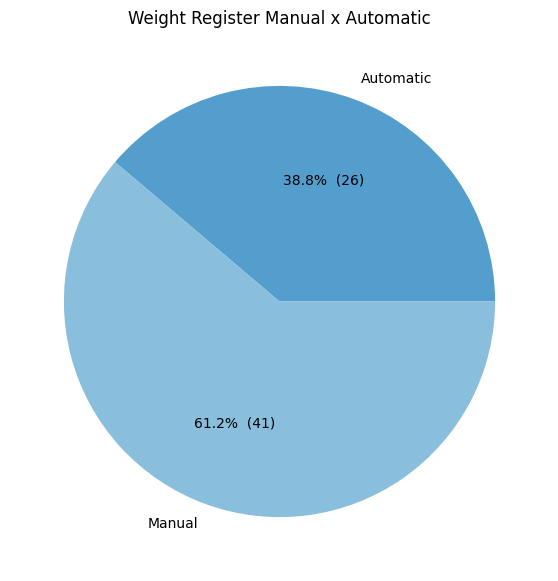

In [54]:
#Counting the number of manual reports.
grpManReport = weightInfo.groupby("IsManualReport")\
    .agg({
        "Id": "count"
    }).reset_index()

grpManReport["IsManualReport"] = grpManReport["IsManualReport"].replace({
    False: "Automatic",
    True: "Manual"
})

cmap = sns.color_palette("Blues_r").as_hex()[2:]

plt.subplots(figsize=(7, 7))
plt.pie(x=grpManReport["Id"], 
        labels = grpManReport["IsManualReport"],
        autopct = make_autopct(grpManReport["Id"]),
        colors = cmap)
plt.title(label="Weight Register Manual x Automatic")
plt.show()

    Most of the weight reports were manual.

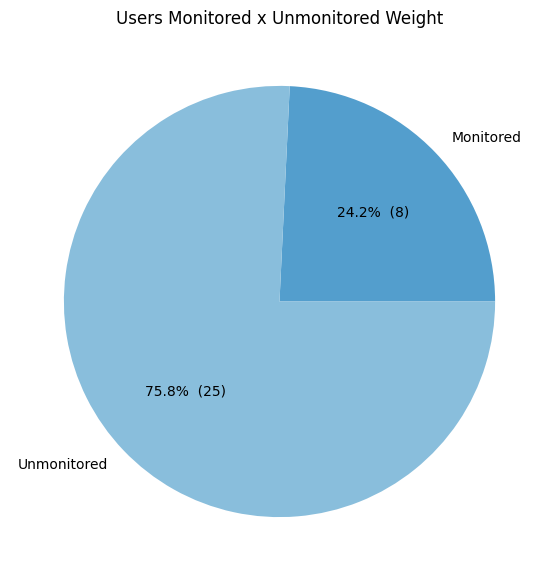

In [55]:
plt.subplots(figsize=(7, 7))
plt.pie(x=monitWeight["values"], 
        labels = monitWeight["labels"],
        autopct = make_autopct(monitWeight["values"]),
        colors = cmap)
plt.title(label="Users Monitored x Unmonitored Weight")
plt.show()

    Most of the users don't use the weight monitoring.

#### 3.2 Sleep Monitoring

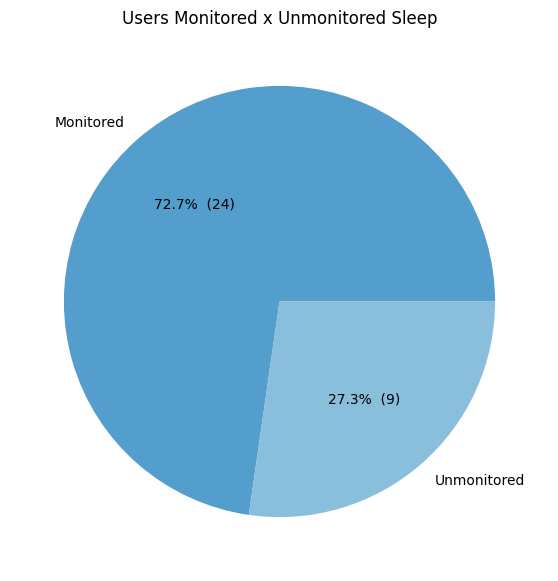

In [56]:
plt.subplots(figsize=(7, 7))
plt.pie(x=monitSleep["values"], 
        labels = monitSleep["labels"],
        autopct = make_autopct(monitSleep["values"]),
        colors = cmap)
plt.title(label="Users Monitored x Unmonitored Sleep")
plt.show()

        Most of the users make use the sleep monitoring.

#### 3.3 Conclusions 3:
    Most users use sleep tracking, but the vast majority don't use weight tracking. We can see that most of the weight monitoring records are manual, which leads us to believe that there is a difficulty on keeping this informations up to date.

### 4.0 Concluding Remarks

#### 4.1 Findings:
    Most workouts occur from Tuesday to Thursday, still, these workouts are moderate. The longest workouts are on Fridays and Saturdays. There is a preference for more intense workouts from Saturday to Monday.

    Training schedules are consistent throughout the week, although people start training later on the weekends. There is a curve that starts to climb at 9:00AM and drops around 9:00PM (12 hours of plenty activity). The peak of the curve happens at afternoons (when most of the workouts take place).

    There is a possible usability issue to explore: Most users do not track their weight progress, and those that do so usually use manual logging. 

#### 4.2 Recommendations:
##### 4.2.1 Marketing:
    The campaigns might take place during high training hours (9:00AM to 9:00PM) in the case we want to reach users at the gym environment, or during late evening or early morning for those that be relaxing at home. It depends on the strategy to be considered.

    There is an audience that trains intensively on weekends, perhaps a specialized campaign for this segment could take place during the weekends at the morning or by evening.

##### 4.2.2 Feature Opportunity:
    Most users do not track their weight with the system. 
    Going deeper, we can find that most weight entries are done manually. Perhaps there is room for an automated system that can synchronize with scales or treadmills. Or, better yet, some notification can be sent when workout tracking hasn't been detected for some time.

### 5.0 Data Limitations
    We found some interesting insights. However, there are clear limitations to the data at the time of this analysis.

#### 5.1 Small Population Sample:
    There were only 33 users observed, and all of them seemed to be in the habit of exercising. So we do not seem to have any casual or beginner users.

#### 5.2 Short Amount of Time:
    We only have data for one month. We cannot assume that this pattern occurs at all times of the year, so this analysis should be taken with a grain of salt.

#### 5.3 Pandemics:
    During 2020 we had the unfortunate event of the Covid-19 pandemic. This event certainly changed the way we live and our habits, so it should be another point to consider when taking note of the results of this analysis.